In [1]:
import pandas as pd
import numpy as np
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
from math import sqrt
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv('index2018.csv')
df=data.copy()
df.head()

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


In [3]:
df['date']=pd.to_datetime(df['date'],dayfirst=True)
df.head()

,date,spx,dax,ftse,nikkei
0,1994-01-07,469.90,2224.95,3445.98,18124.01
1,1994-01-10,475.27,2225.00,3440.58,18443.44
2,1994-01-11,474.13,2228.10,3413.77,18485.25
3,1994-01-12,474.17,2182.06,3372.02,18793.88
4,1994-01-13,472.47,2142.37,3360.01,18577.26


In [4]:
df.set_index('date',inplace=True)
df.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


In [5]:
df=df.asfreq('b')

In [6]:
df.isnull().sum()

spx       8
dax       8
ftse      8
nikkei    8
dtype: int64

In [7]:
df['spx']=df['spx'].fillna(method='ffill')

In [8]:
df['ftse']=df['ftse'].fillna(method='bfill')

In [9]:
df['dax']=df['dax'].fillna(df['dax'].mean())

In [10]:
df['market_value']=df['ftse']
del df['ftse']
df.head()

,spx,dax,nikkei,market_value
date,,,,
1994-01-07,469.90,2224.95,18124.01,3445.98
1994-01-10,475.27,2225.00,18443.44,3440.58
1994-01-11,474.13,2228.10,18485.25,3413.77
1994-01-12,474.17,2182.06,18793.88,3372.02
1994-01-13,472.47,2142.37,18577.26,3360.01


In [11]:
df.isnull().sum()

spx             0
dax             0
nikkei          8
market_value    0
dtype: int64

In [12]:
df['returns']=df.market_value.pct_change(1).mul(100)
df=df.iloc[1:]

In [13]:
sts.adfuller(df.returns)

(-15.139421215023173,
 7.045534847762472e-28,
 33,
 6242,
 {'1%': -3.4313980601154883,
  '5%': -2.8620031495251346,
  '10%': -2.567016531562964},
 19028.497135210317)

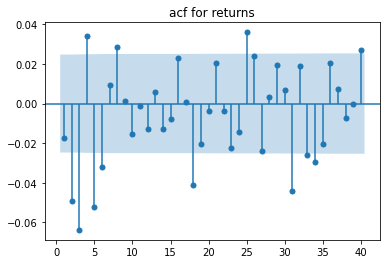

In [14]:
sgt.plot_acf(df.returns[1:],zero=False,lags=40)
plt.title('acf for returns')
plt.show()

## MA(1) model

In [15]:
model_ret_ma_1=ARMA(df.returns[1:],order=(0,1))
results_ret_ma_1=model_ret_ma_1.fit()
results_ret_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 6275
Model:                     ARMA(0, 1)   Log Likelihood               -9596.589
Method:                       css-mle   S.D. of innovations              1.117
Date:                Tue, 01 Feb 2022   AIC                          19199.178
Time:                        12:25:07   BIC                          19219.411
Sample:                    01-11-1994   HQIC                         19206.189
                         - 01-29-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0190      0.014      1.376      0.169      -0.008       0.046
ma.L1.returns    -0.0193      0.013     -1.444      0.149      -0.045       0.007
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           51.8864           +0.0000j           51.8864            0.0000
-----------------------------------------------------------------------------
"""

In [16]:
def llr_test(mod_1,mod_2,DF=1):
    L1=mod_1.fit().llf
    L2=mod_2.fit().llf
    LR=(2*(L2-L1))
    P=chi2.sf(LR,DF).round(3)
    return P

In [17]:
model_ret_ma_2=ARMA(df.returns[1:],order=(0,2))
results_ret_ma_2=model_ret_ma_2.fit()
print(results_ret_ma_2.summary())
print(llr_test(model_ret_ma_1,model_ret_ma_2))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 6275
Model:                     ARMA(0, 2)   Log Likelihood               -9588.569
Method:                       css-mle   S.D. of innovations              1.115
Date:                Tue, 01 Feb 2022   AIC                          19185.138
Time:                        12:25:07   BIC                          19212.115
Sample:                    01-11-1994   HQIC                         19194.485
                         - 01-29-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0190      0.013      1.461      0.144      -0.007       0.045
ma.L1.returns    -0.0251      0.013     -1.975      0.048      -0.050      -0.000
ma.L2.returns    -0.0496      0.012     

In [18]:
model_ret_ma_3=ARMA(df.returns[1:],order=(0,3))
results_ret_ma_3=model_ret_ma_3.fit()
print(results_ret_ma_3.summary())
print(llr_test(model_ret_ma_2,model_ret_ma_3))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 6275
Model:                     ARMA(0, 3)   Log Likelihood               -9573.022
Method:                       css-mle   S.D. of innovations              1.113
Date:                Tue, 01 Feb 2022   AIC                          19156.043
Time:                        12:25:08   BIC                          19189.765
Sample:                    01-11-1994   HQIC                         19167.727
                         - 01-29-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0191      0.012      1.587      0.112      -0.004       0.043
ma.L1.returns    -0.0175      0.013     -1.382      0.167      -0.042       0.007
ma.L2.returns    -0.0547      0.012     

In [19]:
model_ret_ma_4=ARMA(df.returns[1:],order=(0,4))
results_ret_ma_4=model_ret_ma_4.fit()
print(results_ret_ma_4.summary())
print(llr_test(model_ret_ma_3,model_ret_ma_4))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 6275
Model:                     ARMA(0, 4)   Log Likelihood               -9570.237
Method:                       css-mle   S.D. of innovations              1.112
Date:                Tue, 01 Feb 2022   AIC                          19152.473
Time:                        12:25:08   BIC                          19192.939
Sample:                    01-11-1994   HQIC                         19166.494
                         - 01-29-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0191      0.012      1.536      0.124      -0.005       0.043
ma.L1.returns    -0.0169      0.013     -1.342      0.180      -0.042       0.008
ma.L2.returns    -0.0548      0.013     

In [20]:
model_ret_ma_5=ARMA(df.returns[1:],order=(0,5))
results_ret_ma_5=model_ret_ma_5.fit()
print(results_ret_ma_5.summary())
print(llr_test(model_ret_ma_4,model_ret_ma_5))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 6275
Model:                     ARMA(0, 5)   Log Likelihood               -9562.502
Method:                       css-mle   S.D. of innovations              1.111
Date:                Tue, 01 Feb 2022   AIC                          19139.005
Time:                        12:25:09   BIC                          19186.215
Sample:                    01-11-1994   HQIC                         19155.362
                         - 01-29-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0191      0.012      1.620      0.105      -0.004       0.042
ma.L1.returns    -0.0212      0.013     -1.681      0.093      -0.046       0.004
ma.L2.returns    -0.0504      0.013     

In [21]:
model_ret_ma_6=ARMA(df.returns[1:],order=(0,6))
results_ret_ma_6=model_ret_ma_6.fit()
print(results_ret_ma_6.summary())
print(llr_test(model_ret_ma_5,model_ret_ma_6))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 6275
Model:                     ARMA(0, 6)   Log Likelihood               -9559.844
Method:                       css-mle   S.D. of innovations              1.110
Date:                Tue, 01 Feb 2022   AIC                          19135.688
Time:                        12:25:11   BIC                          19189.642
Sample:                    01-11-1994   HQIC                         19154.382
                         - 01-29-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0191      0.011      1.670      0.095      -0.003       0.041
ma.L1.returns    -0.0194      0.013     -1.539      0.124      -0.044       0.005
ma.L2.returns    -0.0496      0.013     

In [22]:
model_ret_ma_7=ARMA(df.returns[1:],order=(0,7))
results_ret_ma_7=model_ret_ma_7.fit()
print(results_ret_ma_7.summary())
print(llr_test(model_ret_ma_6,model_ret_ma_7))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 6275
Model:                     ARMA(0, 7)   Log Likelihood               -9559.709
Method:                       css-mle   S.D. of innovations              1.110
Date:                Tue, 01 Feb 2022   AIC                          19137.418
Time:                        12:25:14   BIC                          19198.117
Sample:                    01-11-1994   HQIC                         19158.449
                         - 01-29-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0191      0.011      1.659      0.097      -0.003       0.042
ma.L1.returns    -0.0200      0.013     -1.578      0.115      -0.045       0.005
ma.L2.returns    -0.0499      0.013     

In [23]:
model_ret_ma_8=ARMA(df.returns[1:],order=(0,8))
results_ret_ma_8=model_ret_ma_8.fit()
print(results_ret_ma_8.summary())
print(llr_test(model_ret_ma_7,model_ret_ma_8))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 6275
Model:                     ARMA(0, 8)   Log Likelihood               -9557.350
Method:                       css-mle   S.D. of innovations              1.110
Date:                Tue, 01 Feb 2022   AIC                          19134.700
Time:                        12:25:18   BIC                          19202.143
Sample:                    01-11-1994   HQIC                         19158.068
                         - 01-29-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0191      0.012      1.610      0.107      -0.004       0.042
ma.L1.returns    -0.0196      0.013     -1.552      0.121      -0.044       0.005
ma.L2.returns    -0.0499      0.013     

In [24]:
llr_test(model_ret_ma_6,model_ret_ma_8,DF=2)

0.083

In [25]:
## so model ma6 is a better predictor of time series than ma8 as p=.083 which is greater than .05

## residuals of returns

In [26]:
df['res_ret_ma_8']=results_ret_ma_8.resid[1:]

In [27]:
df.res_ret_ma_8.mean()

7.653426380632587e-05

In [28]:
df.res_ret_ma_8.var()

1.2318582006638863

In [29]:
round(sqrt(df.res_ret_ma_8.var()),3)

1.11

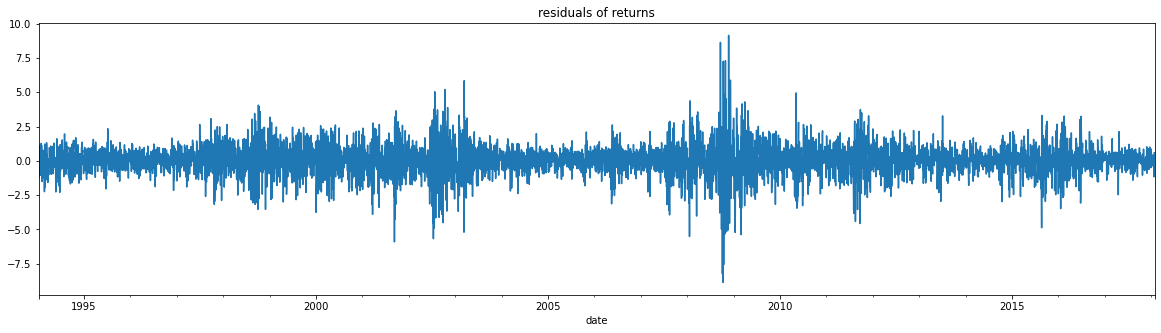

In [30]:
df.res_ret_ma_8.plot(figsize=(20,5))
plt.title('residuals of returns')
plt.show()

In [31]:
sts.adfuller(df.res_ret_ma_8[2:])

(-79.2152506406126,
 0.0,
 0,
 6273,
 {'1%': -3.4313928786754726,
  '5%': -2.8620008601902893,
  '10%': -2.5670153128952853},
 19020.644133192232)

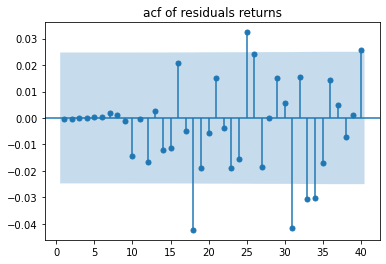

In [32]:
sgt.plot_acf(df.res_ret_ma_8[2:],zero=False,lags=40)
plt.title('acf of residuals returns')
plt.show()

## normalisation for returns

In [33]:
bench_ret=df.returns[1]
df['norm_ret']=df.returns.div(bench_ret).mul(100)

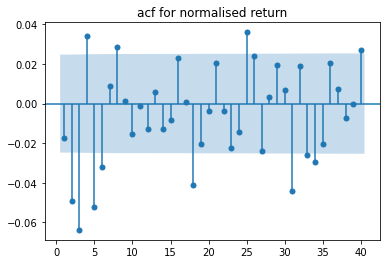

In [34]:
sgt.plot_acf(df.norm_ret,zero=False,lags=40)
plt.title('acf for normalised return')
plt.show()## this comes similar to acf plot for return i.e. our series is already optimised

In [35]:
model_norm_ret_ma_8=ARMA(df.returns[1:],order=(0,8))
results_norm_ret_ma_8=model_norm_ret_ma_8.fit()
results_norm_ret_ma_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 6275
Model:                     ARMA(0, 8)   Log Likelihood               -9557.350
Method:                       css-mle   S.D. of innovations              1.110
Date:                Tue, 01 Feb 2022   AIC                          19134.700
Time:                        12:25:28   BIC                          19202.143
Sample:                    01-11-1994   HQIC                         19158.068
                         - 01-29-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0191      0.012      1.610      0.107      -0.004       0.042
ma.L1.returns    -0.0196      0.013     -1.552      0.121      -0.044       0.005
ma.L2.returns    -0.0499      0.013     -3.959      0.000      -0.075      -0.025
ma.L3.returns    -0.0675      0.013     -5.338      0.000      -0.092      -0.043
ma.L4.returns     0.0314      0.013      2.481      0.013       0.007       0.056
ma.L5.returns    -0.0522      0.013     -4.083      0.000      -0.077      -0.027
ma.L6.returns    -0.0307      0.013     -2.376      0.018      -0.056      -0.005
ma.L7.returns     0.0067      0.013      0.523      0.601      -0.018       0.032
ma.L8.returns     0.0270      0.012      2.174      0.030       0.003       0.051
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.5380           -0.4213j            1.5946           -0.0426
MA.2            1.5380           +0.4213j            1.5946            0.0426
MA.3            0.5976           -1.3618j            1.4872           -0.1842
MA.4            0.5976           +1.3618j            1.4872            0.1842
MA.5           -0.7721           -1.3472j            1.5527           -0.3328
MA.6           -0.7721           +1.3472j            1.5527            0.3328
MA.7           -1.4869           -0.7193j            1.6517           -0.4283
MA.8           -1.4869           +0.7193j            1.6517            0.4283
-----------------------------------------------------------------------------
"""

In [36]:
## but in our case ma 6 was found to be beeter suited model so making normalised ma6 model 

In [37]:
##ma6
model_norm_ret_ma_6=ARMA(df.returns[1:],order=(0,6))
results_norm_ret_ma_6=model_norm_ret_ma_6.fit()
results_norm_ret_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 6275
Model:                     ARMA(0, 6)   Log Likelihood               -9559.844
Method:                       css-mle   S.D. of innovations              1.110
Date:                Tue, 01 Feb 2022   AIC                          19135.688
Time:                        12:25:29   BIC                          19189.642
Sample:                    01-11-1994   HQIC                         19154.382
                         - 01-29-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0191      0.011      1.670      0.095      -0.003       0.041
ma.L1.returns    -0.0194      0.013     -1.539      0.124      -0.044       0.005
ma.L2.returns    -0.0496      0.013     -3.927      0.000      -0.074      -0.025
ma.L3.returns    -0.0665      0.013     -5.252      0.000      -0.091      -0.042
ma.L4.returns     0.0300      0.012      2.440      0.015       0.006       0.054
ma.L5.returns    -0.0504      0.013     -3.916      0.000      -0.076      -0.025
ma.L6.returns    -0.0298      0.013     -2.304      0.021      -0.055      -0.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.5221           -0.0000j            1.5221           -0.0000
MA.2            0.7984           -1.5406j            1.7352           -0.1739
MA.3            0.7984           +1.5406j            1.7352            0.1739
MA.4           -1.1025           -1.2634j            1.6768           -0.3642
MA.5           -1.1025           +1.2634j            1.6768            0.3642
MA.6           -2.6061           -0.0000j            2.6061           -0.5000
-----------------------------------------------------------------------------
"""

## normalisation for return residuals

In [38]:
df['res_norm_ret_ma_8']=results_norm_ret_ma_8.resid[1:]

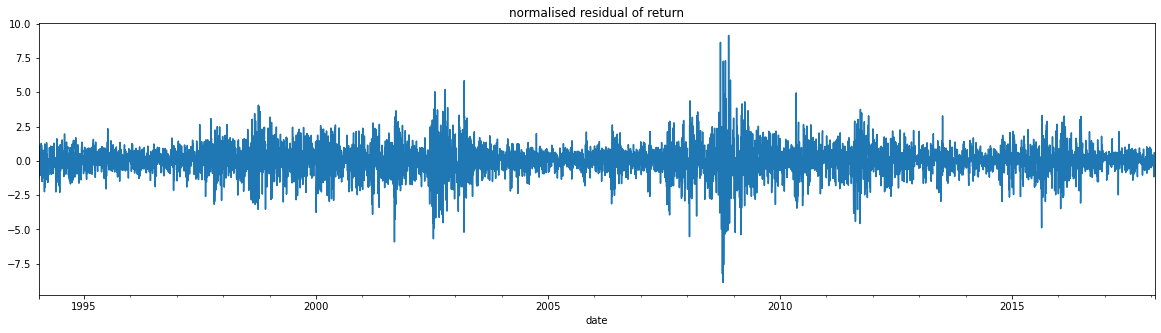

In [39]:
df['res_norm_ret_ma_8'].plot(figsize=(20,5))
plt.title('normalised residual of return')
plt.show()

sgt.plot_acf(df.res_norm_ret_ma_8[2:],zero=False,lags=40)
plt.title('acf of normalised residuals returns')
plt.show()

In [40]:
## this acf suggest that data resembles white noise so our model choice is correct
##white noise means that acf shows no pattern and values are mostly insignificant

## MA model for prices(market_value i.e. ftse)

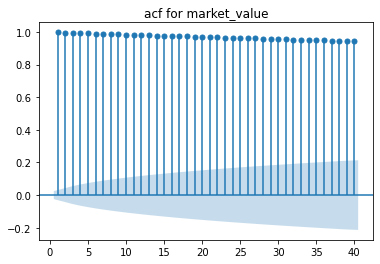

In [41]:
sgt.plot_acf(df.market_value,zero=False,lags=40)
plt.title('acf for market_value')
plt.show()

In [42]:
## this shows that higher ma model will be prefered to lower lag model i.e. infinite lag ma model{ma(p+1)>ma(p)}, since no such thing exist so no ma model would be correct estimator for prices 

In [43]:
## so we conclude that ma model does not perform well for non stationary data they are good only for stationary data 

 ## ARMA MODEL

In [44]:
model_ret_ar1_ma1=ARMA(df.returns[1:],order=(1,1))
result_ret_ar1_ma1=model_ret_ar1_ma1.fit()
result_ret_ar1_ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 6275
Model:                     ARMA(1, 1)   Log Likelihood               -9581.344
Method:                       css-mle   S.D. of innovations              1.114
Date:                Tue, 01 Feb 2022   AIC                          19170.687
Time:                        12:25:31   BIC                          19197.665
Sample:                    01-11-1994   HQIC                         19180.034
                         - 01-29-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0191      0.011      1.755      0.079      -0.002       0.040
ar.L1.returns     0.8180      0.063     12.955      0.000       0.694       0.942
ma.L1.returns    -0.8595      0.056    -15.270      0.000      -0.970      -0.749
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2226           +0.0000j            1.2226            0.0000
MA.1            1.1635           +0.0000j            1.1635            0.0000
-----------------------------------------------------------------------------
"""

In [45]:
model_ret_ar1=ARMA(df.returns[1:],order=(1,0))
model_ret_ma1=ARMA(df.returns[1:],order=(0,1))

In [46]:
print('arma vs ar',llr_test(model_ret_ar1,model_ret_ar1_ma1))
print('arma vs ma',llr_test(model_ret_ma1,model_ret_ar1_ma1))

arma vs ar 0.0
arma vs ma 0.0


In [47]:
## this shows that ARMA model is better than ar and ma model individually as p value is less than .05

## Higher lag ARMA model

In [48]:
## by pacf ealier for ar model we came to know that ar8 was better suited model and by acf of ma we came to know that ma6 is better suited model so ARMA(8,6)

In [49]:
## but ARMA(8,6) is would be quite complex and time consuming and after running the model we found that 10 out 14 coefficients were insignificant 

In [50]:
## so we make it half i.e. 4,3 and lets say we start with 3,3 ARMA model 

In [51]:
model_ret_ar3_ma3=ARMA(df.returns[1:],order=(3,3))
result_ret_ar3_ma3=model_ret_ar3_ma3.fit()
result_ret_ar3_ma3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 6275
Model:                     ARMA(3, 3)   Log Likelihood               -9564.486
Method:                       css-mle   S.D. of innovations              1.111
Date:                Tue, 01 Feb 2022   AIC                          19144.973
Time:                        12:25:38   BIC                          19198.928
Sample:                    01-11-1994   HQIC                         19163.667
                         - 01-29-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0191      0.011      1.672      0.095      -0.003       0.041
ar.L1.returns    -0.1028      0.099     -1.034      0.301      -0.298       0.092
ar.L2.returns    -0.2269      0.088     -2.577      0.010      -0.399      -0.054
ar.L3.returns     0.5298      0.127      4.167      0.000       0.281       0.779
ma.L1.returns     0.0872      0.095      0.920      0.357      -0.098       0.273
ma.L2.returns     0.1654      0.086      1.926      0.054      -0.003       0.334
ma.L3.returns    -0.6025      0.118     -5.114      0.000      -0.833      -0.372
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.5130           -1.0172j            1.1393           -0.3243
AR.2           -0.5130           +1.0172j            1.1393            0.3243
AR.3            1.4542           -0.0000j            1.4542           -0.0000
MA.1           -0.5261           -0.9871j            1.1186           -0.3279
MA.2           -0.5261           +0.9871j            1.1186            0.3279
MA.3            1.3267           -0.0000j            1.3267           -0.0000
-----------------------------------------------------------------------------
"""

In [52]:
## now running the llr test for arma(1,1) and arma(3,3)
print('llr test p value',llr_test(model_ret_ar1_ma1,model_ret_ar3_ma3))

llr test p value 0.0


In [53]:
## since the arma)(3,3) is the better predictor but phi1 and thita 1 values both are insignificant which were significant acoording to pacf and pacf plots earlier so we need choose the model which comes between(1,1) and (3,3) model

In [54]:
##ARMA(3,2)
model_ret_ar3_ma2=ARMA(df.returns[1:],order=(3,2))
result_ret_ar3_ma2=model_ret_ar3_ma2.fit()
result_ret_ar3_ma2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 6275
Model:                     ARMA(3, 2)   Log Likelihood               -9568.839
Method:                       css-mle   S.D. of innovations              1.112
Date:                Tue, 01 Feb 2022   AIC                          19151.678
Time:                        12:25:45   BIC                          19198.888
Sample:                    01-11-1994   HQIC                         19168.036
                         - 01-29-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0190      0.013      1.477      0.140      -0.006       0.044
ar.L1.returns    -0.6744      0.117     -5.749      0.000      -0.904      -0.444
ar.L2.returns    -0.3347      0.166     -2.015      0.044      -0.660      -0.009
ar.L3.returns    -0.0951      0.013     -7.498      0.000      -0.120      -0.070
ma.L1.returns     0.6574      0.118      5.584      0.000       0.427       0.888
ma.L2.returns     0.2757      0.168      1.646      0.100      -0.053       0.604
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.5633           -2.0195j            2.0966           -0.2933
AR.2           -0.5633           +2.0195j            2.0966            0.2933
AR.3           -2.3919           -0.0000j            2.3919           -0.5000
MA.1           -1.1921           -1.4852j            1.9045           -0.3576
MA.2           -1.1921           +1.4852j            1.9045            0.3576
-----------------------------------------------------------------------------
"""

In [55]:
## since all the coefficents are significant this is the better predictor

In [56]:
##ARMA(2,3)
model_ret_ar2_ma3=ARMA(df.returns[1:],order=(2,3))
result_ret_ar2_ma3=model_ret_ar2_ma3.fit()
result_ret_ar2_ma3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 6275
Model:                     ARMA(2, 3)   Log Likelihood               -9567.636
Method:                       css-mle   S.D. of innovations              1.112
Date:                Tue, 01 Feb 2022   AIC                          19149.271
Time:                        12:25:46   BIC                          19196.482
Sample:                    01-11-1994   HQIC                         19165.629
                         - 01-29-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0190      0.012      1.533      0.125      -0.005       0.043
ar.L1.returns    -0.5198      0.173     -3.009      0.003      -0.858      -0.181
ar.L2.returns    -0.0601      0.230     -0.261      0.794      -0.512       0.392
ma.L1.returns     0.5013      0.172      2.909      0.004       0.164       0.839
ma.L2.returns    -0.0027      0.230     -0.012      0.991      -0.453       0.447
ma.L3.returns    -0.0999      0.013     -7.703      0.000      -0.125      -0.074
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.8882           +0.0000j            2.8882            0.5000
AR.2           -5.7619           +0.0000j            5.7619            0.5000
MA.1           -1.4623           -1.1476j            1.8589           -0.3941
MA.2           -1.4623           +1.1476j            1.8589            0.3941
MA.3            2.8981           -0.0000j            2.8981           -0.0000
-----------------------------------------------------------------------------
"""

In [57]:
## since two value of coefficient here becomes insignificant so better we go with arma(3,3)

In [58]:
## ARMA(3,1)
model_ret_ar3_ma1=ARMA(df.returns[1:],order=(3,1))
result_ret_ar3_ma1=model_ret_ar3_ma1.fit()
result_ret_ar3_ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 6275
Model:                     ARMA(3, 1)   Log Likelihood               -9569.775
Method:                       css-mle   S.D. of innovations              1.112
Date:                Tue, 01 Feb 2022   AIC                          19151.550
Time:                        12:25:48   BIC                          19192.016
Sample:                    01-11-1994   HQIC                         19165.571
                         - 01-29-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0190      0.013      1.511      0.131      -0.006       0.044
ar.L1.returns    -0.5193      0.100     -5.219      0.000      -0.714      -0.324
ar.L2.returns    -0.0597      0.014     -4.187      0.000      -0.088      -0.032
ar.L3.returns    -0.0924      0.013     -7.344      0.000      -0.117      -0.068
ma.L1.returns     0.5008      0.100      5.032      0.000       0.306       0.696
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5446           -0.0000j            1.5446           -0.5000
AR.2            0.4491           -2.6092j            2.6476           -0.2229
AR.3            0.4491           +2.6092j            2.6476            0.2229
MA.1           -1.9967           +0.0000j            1.9967            0.5000
-----------------------------------------------------------------------------
"""

In [59]:
print('p value for llr test is',llr_test(model_ret_ar3_ma1,model_ret_ar3_ma2))

p value for llr test is 0.171


In [60]:
##ARMA(2,2)
model_ret_ar2_ma2=ARMA(df.returns[1:],order=(2,2))
result_ret_ar2_ma2=model_ret_ar2_ma2.fit()
result_ret_ar2_ma2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 6275
Model:                     ARMA(2, 2)   Log Likelihood               -9578.029
Method:                       css-mle   S.D. of innovations              1.113
Date:                Tue, 01 Feb 2022   AIC                          19168.059
Time:                        12:25:52   BIC                          19208.525
Sample:                    01-11-1994   HQIC                         19182.080
                         - 01-29-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0191      0.012      1.651      0.099      -0.004       0.042
ar.L1.returns     0.7676      0.222      3.454      0.001       0.332       1.203
ar.L2.returns    -0.1111      0.182     -0.611      0.541      -0.468       0.245
ma.L1.returns    -0.7900      0.223     -3.546      0.000      -1.227      -0.353
ma.L2.returns     0.0721      0.190      0.380      0.704      -0.300       0.444
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7421           +0.0000j            1.7421            0.0000
AR.2            5.1650           +0.0000j            5.1650            0.0000
MA.1            1.4603           +0.0000j            1.4603            0.0000
MA.2            9.5028           +0.0000j            9.5028            0.0000
-----------------------------------------------------------------------------
"""

In [61]:
#ARMA(1,2)and ARMA(2,1) would outperform ARMA (2,2) because two insignificant values of ar and ma second coefficient

In [62]:
##ARMA(1,3)
model_ret_ar1_ma3=ARMA(df.returns[1:],order=(1,3))
result_ret_ar1_ma3=model_ret_ar1_ma3.fit()
result_ret_ar1_ma3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 6275
Model:                     ARMA(1, 3)   Log Likelihood               -9567.667
Method:                       css-mle   S.D. of innovations              1.112
Date:                Tue, 01 Feb 2022   AIC                          19147.334
Time:                        12:25:54   BIC                          19187.800
Sample:                    01-11-1994   HQIC                         19161.355
                         - 01-29-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0191      0.012      1.545      0.122      -0.005       0.043
ar.L1.returns    -0.4825      0.108     -4.480      0.000      -0.694      -0.271
ma.L1.returns     0.4642      0.107      4.320      0.000       0.254       0.675
ma.L2.returns    -0.0622      0.014     -4.423      0.000      -0.090      -0.035
ma.L3.returns    -0.0992      0.013     -7.653      0.000      -0.125      -0.074
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.0724           +0.0000j            2.0724            0.5000
MA.1           -1.6245           -1.0971j            1.9603           -0.4055
MA.2           -1.6245           +1.0971j            1.9603            0.4055
MA.3            2.6223           -0.0000j            2.6223           -0.0000
-----------------------------------------------------------------------------
"""

In [63]:
## llr test between arma(1,3) and arma(3,2) becomes void because arma(1,3) isin't nested in arma(3,2)


In [64]:
## so comparing their llr values and aic critical values manually

## Residuals for Returns

In [65]:
df['res_ret_ar3_ma2']=result_ret_ar3_ma2.resid[1:]

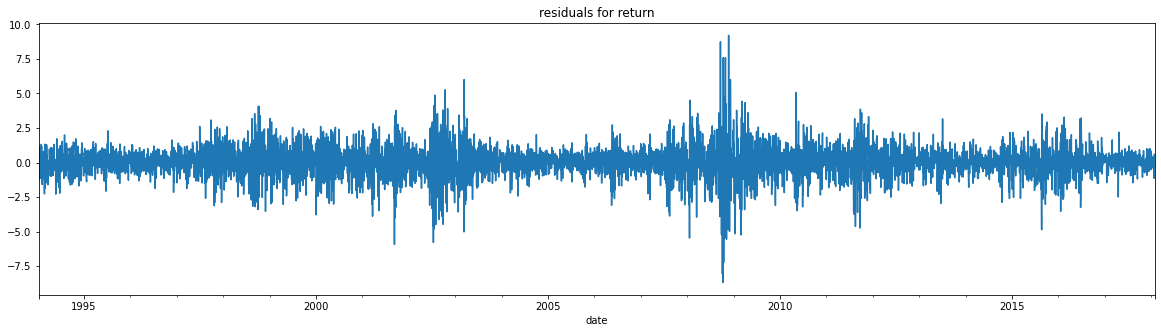

In [66]:
df['res_ret_ar3_ma2'].plot(figsize=(20,5))
plt.title('residuals for return')
plt.show()

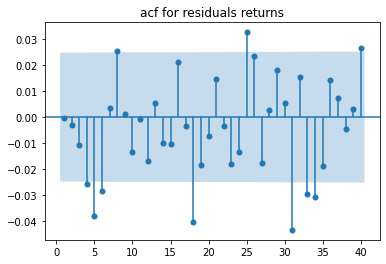

In [67]:
sgt.plot_acf(df['res_ret_ar3_ma2'][2:],zero=False,lags=40)
plt.title('acf for residuals returns')
plt.show()

## Reevaluating the model selection 

In [68]:
df['returns']=df.market_value.pct_change(1).mul(100)
df=df.iloc[1:]

In [69]:
model_ret_ar5_ma5=ARMA(df.returns[1:],order=(5,5))
result_ret_ar5_ma5=model_ret_ar5_ma5.fit(start_ar_lags=7)
result_ret_ar5_ma5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 6274
Model:                     ARMA(5, 5)   Log Likelihood               -9551.912
Method:                       css-mle   S.D. of innovations              1.109
Date:                Tue, 01 Feb 2022   AIC                          19127.825
Time:                        12:26:05   BIC                          19208.755
Sample:                    01-12-1994   HQIC                         19155.866
                         - 01-29-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0192      0.011      1.676      0.094      -0.003       0.042
ar.L1.returns    -0.0656      0.161     -0.407      0.684      -0.381       0.250
ar.L2.returns    -0.5776      0.136     -4.246      0.000      -0.844      -0.311
ar.L3.returns    -0.0914      0.133     -0.686      0.492      -0.352       0.170
ar.L4.returns     0.2618      0.118      2.219      0.027       0.031       0.493
ar.L5.returns     0.1584      0.132      1.203      0.229      -0.100       0.417
ma.L1.returns     0.0457      0.159      0.287      0.774      -0.266       0.358
ma.L2.returns     0.5271      0.135      3.919      0.000       0.263       0.791
ma.L3.returns     0.0089      0.128      0.070      0.945      -0.242       0.260
ma.L4.returns    -0.2668      0.113     -2.365      0.018      -0.488      -0.046
ma.L5.returns    -0.2424      0.128     -1.895      0.058      -0.493       0.008
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0877           -1.0349j            1.0386           -0.2365
AR.2            0.0877           +1.0349j            1.0386            0.2365
AR.3            1.5331           -0.0000j            1.5331           -0.0000
AR.4           -1.6806           -0.9967j            1.9539           -0.4148
AR.5           -1.6806           +0.9967j            1.9539            0.4148
MA.1            1.3635           -0.0000j            1.3635           -0.0000
MA.2            0.1007           -1.0408j            1.0456           -0.2346
MA.3            0.1007           +1.0408j            1.0456            0.2346
MA.4           -1.3330           -0.9953j            1.6636           -0.3979
MA.5           -1.3330           +0.9953j            1.6636            0.3979
-----------------------------------------------------------------------------
"""

In [70]:
##ARMA(1,5)
model_ret_ar1_ma5=ARMA(df.returns[1:],order=(1,5))
result_ret_ar1_ma5=model_ret_ar1_ma5.fit()
result_ret_ar1_ma5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 6274
Model:                     ARMA(1, 5)   Log Likelihood               -9559.707
Method:                       css-mle   S.D. of innovations              1.110
Date:                Tue, 01 Feb 2022   AIC                          19135.414
Time:                        12:26:09   BIC                          19189.367
Sample:                    01-12-1994   HQIC                         19154.108
                         - 01-29-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0192      0.011      1.670      0.095      -0.003       0.042
ar.L1.returns     0.2976      0.153      1.946      0.052      -0.002       0.597
ma.L1.returns    -0.3178      0.153     -2.084      0.037      -0.617      -0.019
ma.L2.returns    -0.0436      0.014     -3.212      0.001      -0.070      -0.017
ma.L3.returns    -0.0523      0.015     -3.407      0.001      -0.082      -0.022
ma.L4.returns     0.0500      0.017      2.991      0.003       0.017       0.083
ma.L5.returns    -0.0617      0.013     -4.775      0.000      -0.087      -0.036
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.3600           +0.0000j            3.3600            0.0000
MA.1           -1.2682           -1.1715j            1.7265           -0.3813
MA.2           -1.2682           +1.1715j            1.7265            0.3813
MA.3            1.5193           -0.0000j            1.5193           -0.0000
MA.4            0.9137           -1.6566j            1.8919           -0.1698
MA.5            0.9137           +1.6566j            1.8919            0.1698
-----------------------------------------------------------------------------
"""

In [71]:
##ARMA(5,1)
model_ret_ar5_ma1=ARMA(df.returns[1:],order=(5,1))
result_ret_ar5_ma1=model_ret_ar5_ma1.fit()
result_ret_ar5_ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 6274
Model:                     ARMA(5, 1)   Log Likelihood               -9558.543
Method:                       css-mle   S.D. of innovations              1.110
Date:                Tue, 01 Feb 2022   AIC                          19133.086
Time:                        12:26:11   BIC                          19187.039
Sample:                    01-12-1994   HQIC                         19151.780
                         - 01-29-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0192      0.012      1.650      0.099      -0.004       0.042
ar.L1.returns     0.3173      0.136      2.333      0.020       0.051       0.584
ar.L2.returns    -0.0465      0.014     -3.446      0.001      -0.073      -0.020
ar.L3.returns    -0.0515      0.015     -3.467      0.001      -0.081      -0.022
ar.L4.returns     0.0499      0.016      3.136      0.002       0.019       0.081
ar.L5.returns    -0.0702      0.013     -5.564      0.000      -0.095      -0.045
ma.L1.returns    -0.3365      0.136     -2.474      0.013      -0.603      -0.070
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.7019           -0.0000j            1.7019           -0.5000
AR.2            1.3797           -0.8990j            1.6468           -0.0919
AR.3            1.3797           +0.8990j            1.6468            0.0919
AR.4           -0.1738           -1.7479j            1.7565           -0.2658
AR.5           -0.1738           +1.7479j            1.7565            0.2658
MA.1            2.9714           +0.0000j            2.9714            0.0000
-----------------------------------------------------------------------------
"""

In [72]:
## arma(5,1) and arma(1,5) both have same dof  so llr cant be deployed but by manualyy comparing ll value of both we cansay that arma(5,1) is better suited 

In [73]:
## now comparing arma(3,2) and arma(5,1) as the final model by comparing the ll values 

In [74]:
print('ll value of arma(5,1)',result_ret_ar5_ma1.llf)
print('ll value of arma(3,2)',result_ret_ar3_ma2.llf)

ll value of arma(5,1) -9558.543008126346
ll value of arma(3,2) -9568.83897967671


In [75]:
## so we take higher log likelihood value model i.e. arma(5,1) model

## Residuals for new model

In [76]:
df['res_ret_ar5_ma1']=result_ret_ar5_ma1.resid

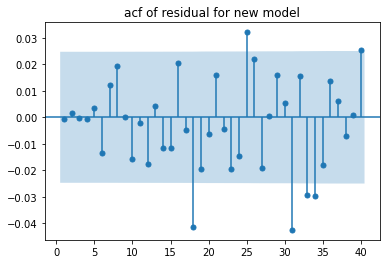

In [77]:
sgt.plot_acf(df.res_ret_ar5_ma1[1:],zero=False,lags=40)
plt.title('acf of residual for new model')
plt.show()

## ARMA model for prices

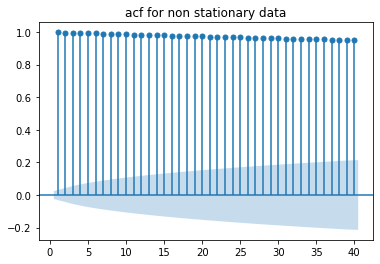

In [78]:
sgt.plot_acf(df.market_value,unbiased=True,zero=False,lags=40)
plt.title('acf for non stationary data')
plt.show()

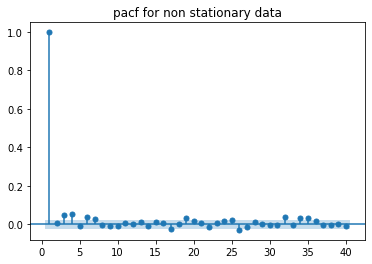

In [79]:
sgt.plot_pacf(df.market_value,lags=40,alpha=.05,zero=False,method=('ols'))
plt.title('pacf for non stationary data')
plt.show()

In [80]:
## ARMA(1,1)
model_ar1_ma1=ARMA(df.market_value,order=(1,1))
results_ar1_ma1=model_ar1_ma1.fit()
results_ar1_ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 6275
Model:                     ARMA(1, 1)   Log Likelihood              -34427.666
Method:                       css-mle   S.D. of innovations             58.384
Date:                Tue, 01 Feb 2022   AIC                          68863.332
Time:                        12:26:12   BIC                          68890.309
Sample:                    01-11-1994   HQIC                         68872.679
                         - 01-29-2018                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5424.3216    671.192      8.082      0.000    4108.810    6739.833
ar.L1.market_value     0.9991      0.001   1733.153      0.000       0.998       1.000
ma.L1.market_value    -0.0093      0.013     -0.696      0.486      -0.035       0.017
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0009           +0.0000j            1.0009            0.0000
MA.1          107.8537           +0.0000j          107.8537            0.0000
-----------------------------------------------------------------------------
"""

In [81]:
df['res_ar1_ma1']=results_ar1_ma1.resid

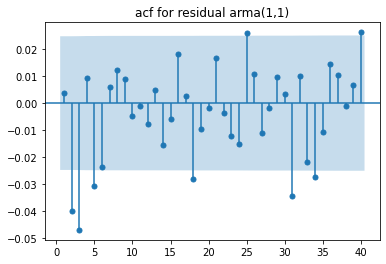

In [82]:
sgt.plot_acf(df.res_ar1_ma1,zero=False,lags=40)
plt.title('acf for residual arma(1,1)')
plt.show()

In [83]:
## first 6 lags are significant according to tutor, but in my case first 5 lags are significant so lets take first arma(6,6)

In [84]:
model_ar6_ma6=ARMA(df.market_value,order=(6,6))
results_ar6_ma6=model_ar6_ma6.fit(start_ar_lags=14)
results_ar6_ma6.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 6275
Model:                     ARMA(6, 6)   Log Likelihood              -34402.685
Method:                       css-mle   S.D. of innovations             58.152
Date:                Tue, 01 Feb 2022   AIC                          68833.369
Time:                        12:26:19   BIC                          68927.790
Sample:                    01-11-1994   HQIC                         68866.085
                         - 01-29-2018                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5424.3989    799.453      6.785      0.000    3857.500    6991.298
ar.L1.market_value     2.4203        nan        nan        nan         nan         nan
ar.L2.market_value    -2.5396        nan        nan        nan         nan         nan
ar.L3.market_value     1.4626      0.002    714.431      0.000       1.459       1.467
ar.L4.market_value    -0.3673      0.008    -46.630      0.000      -0.383      -0.352
ar.L5.market_value     0.2008      0.025      8.192      0.000       0.153       0.249
ar.L6.market_value    -0.1770      0.023     -7.668      0.000      -0.222      -0.132
ma.L1.market_value    -1.4333      0.012   -117.275      0.000      -1.457      -1.409
ma.L2.market_value     1.0878      0.022     49.846      0.000       1.045       1.131
ma.L3.market_value    -0.3402      0.026    -13.154      0.000      -0.391      -0.289
ma.L4.market_value     0.0626      0.027      2.332      0.020       0.010       0.115
ma.L5.market_value    -0.2720      0.032     -8.488      0.000      -0.335      -0.209
ma.L6.market_value     0.0573      0.013      4.486      0.000       0.032       0.082
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.5668           -0.8783j            1.0453           -0.1588
AR.2            0.5668           +0.8783j            1.0453            0.1588
AR.3            1.0006           -0.0000j            1.0006           -0.0000
AR.4            1.1557           -0.0000j            1.1557           -0.0000
AR.5           -1.0775           -1.8196j            2.1147           -0.3351
AR.6           -1.0775           +1.8196j            2.1147            0.3351
MA.1            0.5577           -0.8790j            1.0410           -0.1600
MA.2            0.5577           +0.8790j            1.0410            0.1600
MA.3            1.1292           -0.0000j            1.1292           -0.0000
MA.4           -1.0703           -1.3878j            1.7525           -0.3546
MA.5           -1.0703           +1.3878j            1.7525            0.3546
MA.6            4.6404           -0.0000j            4.6404           -0.0000
-----------------------------------------------------------------------------
"""

In [85]:
model_ar5_ma6=ARMA(df.market_value,order=(5,6))
results_ar5_ma6=model_ar5_ma6.fit(start_ar_lags=9)
results_ar5_ma6.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 6275
Model:                     ARMA(5, 6)   Log Likelihood              -34403.088
Method:                       css-mle   S.D. of innovations             58.155
Date:                Tue, 01 Feb 2022   AIC                          68832.175
Time:                        12:26:27   BIC                          68919.851
Sample:                    01-11-1994   HQIC                         68862.554
                         - 01-29-2018                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5424.3345    797.641      6.800      0.000    3860.988    6987.681
ar.L1.market_value     0.7220      0.186      3.878      0.000       0.357       1.087
ar.L2.market_value     0.3966      0.284      1.398      0.162      -0.159       0.952
ar.L3.market_value    -0.7715      0.206     -3.743      0.000      -1.176      -0.367
ar.L4.market_value     0.4153      0.228      1.825      0.068      -0.031       0.861
ar.L5.market_value     0.2363      0.162      1.458      0.145      -0.081       0.554
ma.L1.market_value     0.2655      0.186      1.428      0.153      -0.099       0.630
ma.L2.market_value    -0.1728      0.167     -1.037      0.300      -0.499       0.154
ma.L3.market_value     0.5856      0.202      2.895      0.004       0.189       0.982
ma.L4.market_value     0.2316      0.162      1.429      0.153      -0.086       0.549
ma.L5.market_value    -0.0565      0.016     -3.611      0.000      -0.087      -0.026
ma.L6.market_value    -0.0778      0.016     -4.957      0.000      -0.109      -0.047
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0007           -0.0000j            1.0007           -0.0000
AR.2            0.6287           -0.9544j            1.1428           -0.1573
AR.3            0.6287           +0.9544j            1.1428            0.1573
AR.4           -1.1172           -0.0000j            1.1172           -0.5000
AR.5           -2.8986           -0.0000j            2.8986           -0.5000
MA.1            0.6017           -0.9524j            1.1266           -0.1603
MA.2            0.6017           +0.9524j            1.1266            0.1603
MA.3           -1.1062           -0.0000j            1.1062           -0.5000
MA.4            2.2483           -0.0000j            2.2483           -0.0000
MA.5           -1.5356           -1.3087j            2.0176           -0.3877
MA.6           -1.5356           +1.3087j            2.0176            0.3877
-----------------------------------------------------------------------------
"""

In [86]:
model_ar6_ma1=ARMA(df.market_value,order=(6,1))
results_ar6_ma1=model_ar6_ma1.fit(start_ar_lags=14)
results_ar6_ma1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 6275
Model:                     ARMA(6, 1)   Log Likelihood              -34405.191
Method:                       css-mle   S.D. of innovations             58.175
Date:                Tue, 01 Feb 2022   AIC                          68828.383
Time:                        12:26:32   BIC                          68889.082
Sample:                    01-11-1994   HQIC                         68849.414
                         - 01-29-2018                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5424.3229    818.493      6.627      0.000    3820.106    7028.539
ar.L1.market_value     1.3552      0.027     50.297      0.000       1.302       1.408
ar.L2.market_value    -0.4022      0.030    -13.506      0.000      -0.461      -0.344
ar.L3.market_value     0.0096      0.022      0.446      0.655      -0.033       0.052
ar.L4.market_value     0.0647      0.022      2.969      0.003       0.022       0.107
ar.L5.market_value    -0.0725      0.021     -3.412      0.001      -0.114      -0.031
ar.L6.market_value     0.0447      0.013      3.544      0.000       0.020       0.069
ma.L1.market_value    -0.3673      0.030    -12.376      0.000      -0.426      -0.309
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0006           -0.0000j            1.0006           -0.0000
AR.2           -1.9328           -0.0000j            1.9328           -0.5000
AR.3            1.4629           -0.9359j            1.7367           -0.0906
AR.4            1.4629           +0.9359j            1.7367            0.0906
AR.5           -0.1858           -1.9492j            1.9580           -0.2651
AR.6           -0.1858           +1.9492j            1.9580            0.2651
MA.1            2.7224           +0.0000j            2.7224            0.0000
-----------------------------------------------------------------------------
"""

In [87]:
## we are considering the arma(6,6) as all coefficients are significant
##and now plotting acf for the residual of arma(6,6)


In [88]:
df['res_ar6_ma6']=results_ar6_ma6.resid

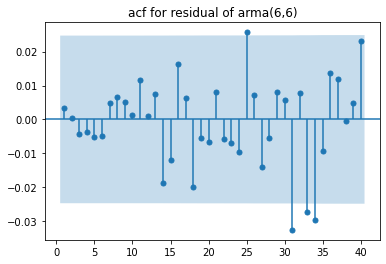

In [89]:
sgt.plot_acf(df.res_ar6_ma6,zero=False,lags=40)
plt.title('acf for residual of arma(6,6)')
plt.show()

In [90]:
## acf resemble no pattern and most of them are insignificant so yes they represent a white nose

In [91]:
print('arma model for non stationary data','llr value is',results_ar6_ma6.llf,'aic value is',results_ar6_ma6.aic)
print('arma model for stationary data','llr value is',result_ret_ar5_ma1.llf,'aic value is',result_ret_ar5_ma1.aic)


arma model for non stationary data llr value is -34402.68461993043 aic value is 68833.36923986085
arma model for stationary data llr value is -9558.543008126346 aic value is 19133.08601625269


In [92]:
##when we compare the llr value and aic values of non stationary and stationary series by arma model then we find that arma model gives better results with stationary data series but in our case it is opposite due to some mistake  